<a href="https://colab.research.google.com/github/stbiadmin/myopia/blob/main/image_degrader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init and Setup

In [9]:
'''
###uncomment to install non-collab-native libraries (run once)
!pip install thispersondoesnotexist
!pip install ipython ipykernel --upgrade
!pip install asyncio

## Install GCS packages
!pip install --q fsspec
!pip install --q gcsfs

##Install Vectice Python library 
!pip install --q vectice[github]==2.2.3
'''

#Import the required packages
from vectice import Experiment
from vectice.api.json import ModelType
from vectice.api.json import JobType
from vectice.api.json import JobArtifactType
from vectice.api.json import ModelVersionStatus
from vectice.api.json.artifact_version import VersionStrategy
import logging
import os
logging.basicConfig(level=logging.INFO)


#import libraries
from thispersondoesnotexist import get_online_person, get_checksum_from_picture,save_picture, Person
import skimage as sk
import skimage.io as skio
import skimage.color as color
import numpy as np
import matplotlib.pyplot as plt
import random
import asyncio
import cv2
import torch
from scipy import signal
from scipy import misc
from scipy import interpolate
from scipy import ndimage
from skimage.transform import resize
import os

In [2]:
#await requires ipython update, this checks version
import IPython
IPython.version_info

(7, 34, 0, '')

In [3]:
#Verify if Vectice python library was installed
!pip3 show vectice

Name: vectice
Version: 2.2.3
Summary: Vectice Python library
Home-page: https://github.com/vectice/vectice-python
Author: Vectice Inc.
Author-email: sdk@vectice.com
License: Apache License 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: python-dotenv, requests, urllib3
Required-by: 


In [7]:
# Specify the API endpoint for Vectice.
# You can specify your API endpoint here in the notebook, but we recommand you to add it to a .env file
os.environ['VECTICE_API_ENDPOINT']= "app.vectice.com"

# To use the Vectice Python library, you first need to authenticate your account using an API key.
# You can generate an API key from the Vectice UI, by going to the "My API Keys" section under your profile's picture
# You can specify your API Token here in the notebook, but we recommand you to add it to a .env file
os.environ['VECTICE_API_TOKEN'] = "lM56j25kR.lAGBa8yxQEVW2egJvY7ZOlM56j25kRodDNrb9nm0LwX34jpP6z"

# Add you project id. The project id can be found in the project settings page in the Vectice UI
project_id = 5194

## Helper Functions

In [58]:
def warpit(im,imname, nsynths):
    for i in range(nsynths):
        dim = 256
        j = random.randint(1,50) + 30; # JPEG compression
        b = 3*random.random() #blur
        g = random.random() + 1; # gamma
        w = 4*np.random.randn() # local geometric warping
        n = random.random()/ 8 # additive noise

        gkern_1D = cv2.getGaussianKernel(11,b+np.finfo(float).eps)
        gkern_2D = np.outer(np.transpose(gkern_1D), gkern_1D )

        im_res = resize(im, [dim,dim])
        x = np.array(list(range(0,dim)))
        y = np.array(list(range(0,dim)))
        x1 = np.array(list(range(1,dim,16)))
        y1 = np.array(list(range(1,dim,16)))

        [xramp,yramp] = np.meshgrid(x,y)
        [xramp2,yramp2] = np.meshgrid(x1,y1)

        xramp2 = xramp2 + w*np.random.randn(xramp2.shape[0],xramp2.shape[1])
        yramp2 = yramp2 + w*np.random.randn(yramp2.shape[0],yramp2.shape[1])

        xramp2 = resize(xramp2, [dim, dim])
        yramp2 = resize(yramp2, [dim, dim])

        im2 = im_res

        for z in range(0,3):
            im2[:,:,z] = signal.convolve2d(im2[:,:,z],gkern_2D , mode='same')
            im2[:,:,z] = ndimage.map_coordinates(im2[:,:,z], [yramp2,xramp2], mode='nearest')
            
        im2 = np.sign(255 * (im2/255)) * np.abs(255 * (im2/255))**g #numpy doesn't allow fractional negative numbers..Workaround
        im2 = im2 + n*np.random.randn(xramp2.shape[1],xramp2.shape[0], 3); # additive noise

        im2 = im2 - im2.min()
        im2 = 255 * im2/im2.max() # scale into [0,255]
        
        plt.imsave('temp.jpg', im2.astype('uint8'))
        im2 = cv2.imread('temp.jpg')
        
        num_rows, num_cols = im2.shape[:2]
        center = (num_cols/2, num_rows/2)
        angle = random.randrange(-5,5,1)
        rot_mat = cv2.getRotationMatrix2D(center,angle, scale =1)
        tx, ty = 10*np.random.randn(), 10* np.random.randn()
        t_map = np.array([
            [1, 0, tx],
            [0, 1, ty]
        ], dtype=np.float32)
        im2 = cv2.warpAffine(im2,rot_mat,(num_cols, num_rows))
        im2 = cv2.warpAffine(im2,t_map,(num_cols, num_rows))
        im2 = im2[30: -30,30: -30,:]
        
       
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow(im)
        plt.subplot(1,2,2)
        plt.imsave('/content/faces/TPDNE/Degraded/'+ imname +'_'+str(i)+'.jpg', cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
        plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
        plt.show()
       
    print(imname + " processed!")   
    
    return


## Data Generation and Preparation

In [47]:
# We create our first experiment for data preparation and specify the workspace and the project we will be working on
# Each experiment only contains one job. Each invokation of the job is called a run.
# autocode = True enables you to track your git changes for your code automatically every time you execute a run (see below).
experiment = Experiment(job="Data Generation and Preparation (faces)_2", project=project_id, job_type=JobType.PREPARATION, auto_code=True)

In [48]:
# The Vectice library automatically detects if there have been changes to the dataset you are using.
# If it detects changes, it will generate a new version of your dataset automatically. 
# For this tutorial, we changed the data since Albert left the company.
# So, the Vectice Python library will create a new dataset version when this code is executed for the first time.
experiment.add_dataset_version(dataset="GAN-created Faces + Random Degradation", version_strategy=VersionStrategy.AUTOMATIC)

ArtifactReference(code=None, dataset=GAN-created Faces + Random Degradation, model=None, version_number=None, version_id=None, version_name=None, version_strategy=VersionStrategy.AUTOMATIC, description=None, )

In [29]:
# Because we are using Colab in this tutorial example we are going to declare a reference to the code
## manually. This will be added as a reference to the run we are going to create next.
# If you are using your local environment with GIT installed or JupyterLab etc... the code
# tracking is automated.
input_code = experiment.add_code_version_uri(git_uri="https://github.com/stbiadmin/myopia",
                                             entrypoint="image_degrader.ipynb") 

In [49]:
# The created dataset version and code version will be automatically attached as inputs of the run
experiment.start(run_properties={"NumFaces": "1", "NumSynths": "0"})

Run(id=15916, job=Job(name=Data Generation and Preparation (faces)_2, id=9556, description=None, type=JobType.PREPARATION), name=Run 2022-05-29T03:09:22.303767, system_name=None, start_date=2022-05-29 03:09:23.594647, end_date=None, duration=None, status=RunStatus.STARTED, inputs=[ArtifactReference(code=None, dataset=GAN-created Faces + Random Degradation, model=None, version_number=None, version_id=None, version_name=None, version_strategy=VersionStrategy.AUTOMATIC, description=None, )], outputs=[])

In [27]:
#if the "faces" folder doesn't exist, create it
if not os.path.exists('../content/faces/TPDNE/'):
  os.makedirs('../content/faces/TPDNE/Original')
  os.makedirs('../content/faces/TPDNE/Degraded/')
else:
  print('Faces folder already exists, skipping...')

In [28]:
n = 10 # number of raw fake faces to download
m = 5 #number of synthetic degraded faces to generate
path = '/content/faces/TPDNE/Original/'

In [29]:
for i in range(n):
  # Using function
  picture =  await get_online_person()
  checksum2 = get_checksum_from_picture(picture)  # Method is optional, defaults to "md5"
  await save_picture(picture, path+str(checksum2)+'.jpg')

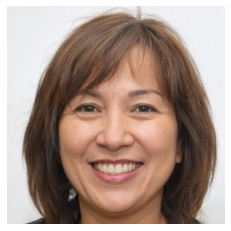

In [40]:
#show all downloaded images
from IPython.core.display import clear_output
from time import sleep
for identity in os.listdir('/content/faces/TPDNE/Original/'):
  clear_output(wait=True)
  tmp_img = plt.imread(path+identity)
  plt.imshow(tmp_img)
  plt.axis('off')
  plt.show()
  sleep(0.1)

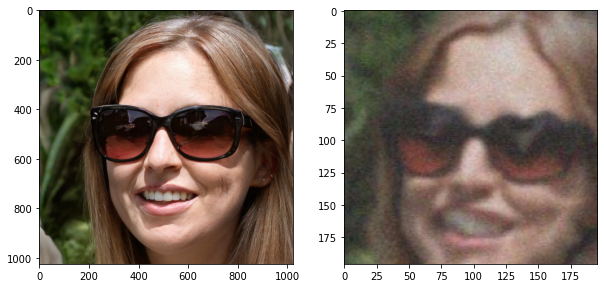

f7f582c7ac073ebd397fc58a4e074ad2 processed!


In [46]:
#cereate random warps of downloaded images
for filename in os.listdir(path):
    if filename.endswith(".jpg"):
        img = plt.imread(path+filename)
        warpit(img, filename[:-4], m)

In [51]:
experiment.complete()

## Pretrained Model Setup

In [8]:
# We create our second experiment for modeling and specify the workspace and the project we will be working on
# Each experiment only contains one job. Each invokation of the job is called a run.
# autocode = True enables you to track your git changes for your code automatically every time you execute a run (see below).
experiment = Experiment(job="Model Setup", project=project_id, job_type=JobType.TRAINING, auto_code=True)

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval()

In [15]:
#if the "objects" folder doesn't exist, create it
if not os.path.exists('../content/objects/'):
  os.mkdir('../content/objects/')
else:
  print('Objects folder already exists, skipping...')
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "/content/objects/dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

Objects folder already exists, skipping...


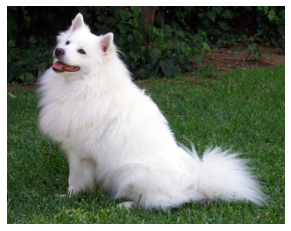

In [19]:
#display the image 
img2 = plt.imread('/content/objects/dog.jpg')
plt.imshow(img2)
plt.axis('off')
plt.show()

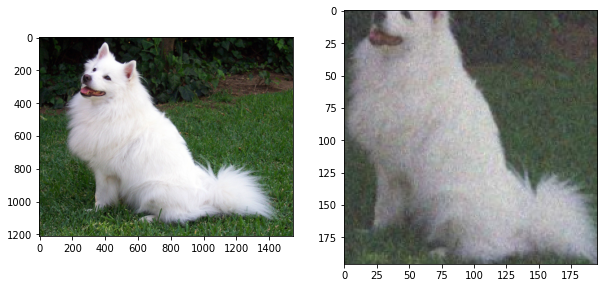

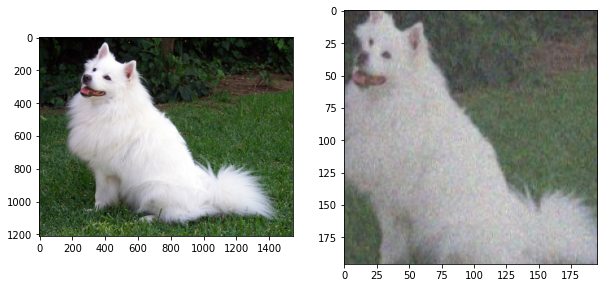

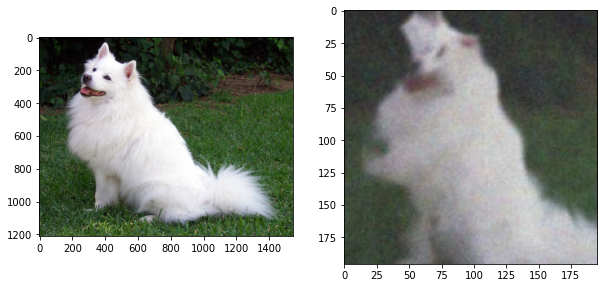

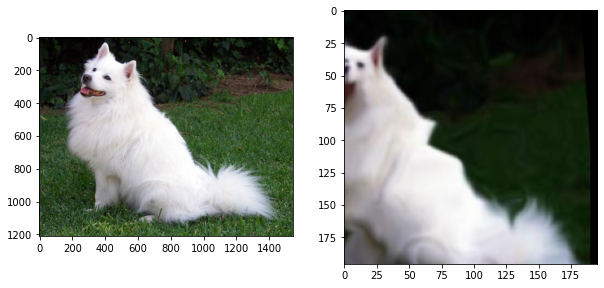

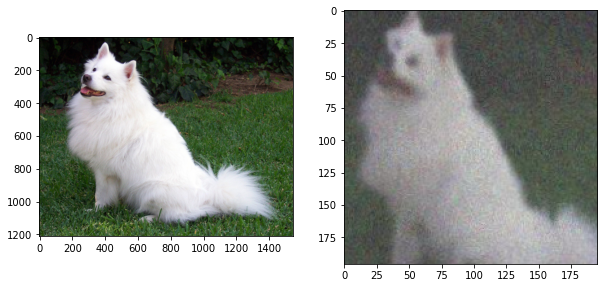

dog processed!


In [60]:
#test warping of dog
warpit(img2,'dog',5)

In [61]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
sample = '/content/faces/TPDNE/Degraded/dog_2.jpg'
input_image = Image.open(sample)
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
  output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
#print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
#print(probabilities)

In [62]:
#if the "labels" folder doesn't exist, create it
if not os.path.exists('../content/labels/'):
  os.mkdir('../content/labels/')
else:
  print('labels folder already exists, skipping...')
# Download ImageNet labels
!wget -P /content/labels/ https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt /content/labels


labels folder already exists, skipping...
--2022-05-29 21:10:10--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘/content/labels/imagenet_classes.txt.1’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-05-29 21:10:10 (57.0 MB/s) - ‘/content/labels/imagenet_classes.txt.1’ saved [10472/10472]

/content/labels: Scheme missing.
FINISHED --2022-05-29 21:10:10--
Total wall clock time: 0.1s
Downloaded: 1 files, 10K in 0s (57.0 MB/s)


In [63]:
# Read the categories
with open("/content/labels/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

Angora 0.1728239208459854
missile 0.08511678129434586
geyser 0.07091414928436279
projectile 0.04882706329226494
Persian cat 0.041493624448776245
